Name: **Luong Nguyen**  
Student ID: **1504210**  

# Introduction to Deep Learning 

## Session05: Reuse convolutional base
____

## Import the packages needed for this assignment

In [1]:
# install keras on google colab
!pip install -q keras
# is GPU working?
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
# import packages
import numpy as np
from keras import models, layers, optimizers
import keras.preprocessing.image as image
import matplotlib.pyplot as plt
import scipy

# Gender detection

The first problem we attempt is gender classification of human images from the cifar100 dataset. The `people` superclass includes `baby, boy, girl, man woman`. We will group `boy` and `man` as a new `male` class, and `girl` and `woman` as `female`.

## Prepare data

### Load data

In [0]:
from keras.datasets import cifar100

(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine') # get 100 classes instead of 20 superclasses

### Explore data

In [159]:
print("x_train shape: %s" % (str(x_train.shape)))
print("y_train shape: %s" % (str(y_train.shape)))
print("x_test shape: %s" % (str(x_test.shape)))
print("y_test shape: %s" % (str(y_test.shape)))

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


Get an array of all labels sorted in ascending order

In [161]:
# https://www.cs.toronto.edu/~kriz/cifar.html
labels = """beaver, dolphin, otter, seal, whale
aquarium fish, flatfish, ray, shark, trout
orchids, poppies, roses, sunflowers, tulips
bottles, bowls, cans, cups, plates
apples, mushrooms, oranges, pears, sweet peppers
clock, keyboard, lamp, telephone, television
bed, chair, couch, table, wardrobe
bee, beetle, butterfly, caterpillar, cockroach
bear, leopard, lion, tiger, wolf
bridge, castle, house, road, skyscraper
cloud, forest, mountain, plain, sea
camel, cattle, chimpanzee, elephant, kangaroo
fox, porcupine, possum, raccoon, skunk
crab, lobster, snail, spider, worm
baby, boy, girl, man, woman
crocodile, dinosaur, lizard, snake, turtle
hamster, mouse, rabbit, shrew, squirrel
maple, oak, palm, pine, willow
bicycle, bus, motorcycle, pickup truck, train
lawn-mower, rocket, streetcar, tank, tractor""".replace('\n', ', ')

labels = labels.split(', ')
labels.sort()
print(labels)

['apples', 'aquarium fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottles', 'bowls', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'cans', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cups', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn-mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple', 'motorcycle', 'mountain', 'mouse', 'mushrooms', 'oak', 'oranges', 'orchids', 'otter', 'palm', 'pears', 'pickup truck', 'pine', 'plain', 'plates', 'poppies', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'roses', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflowers', 'sweet peppers', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulips', 'turtle', 'wardrobe', 'whale', 'willow', 'wolf', 

Plot an example image for every label

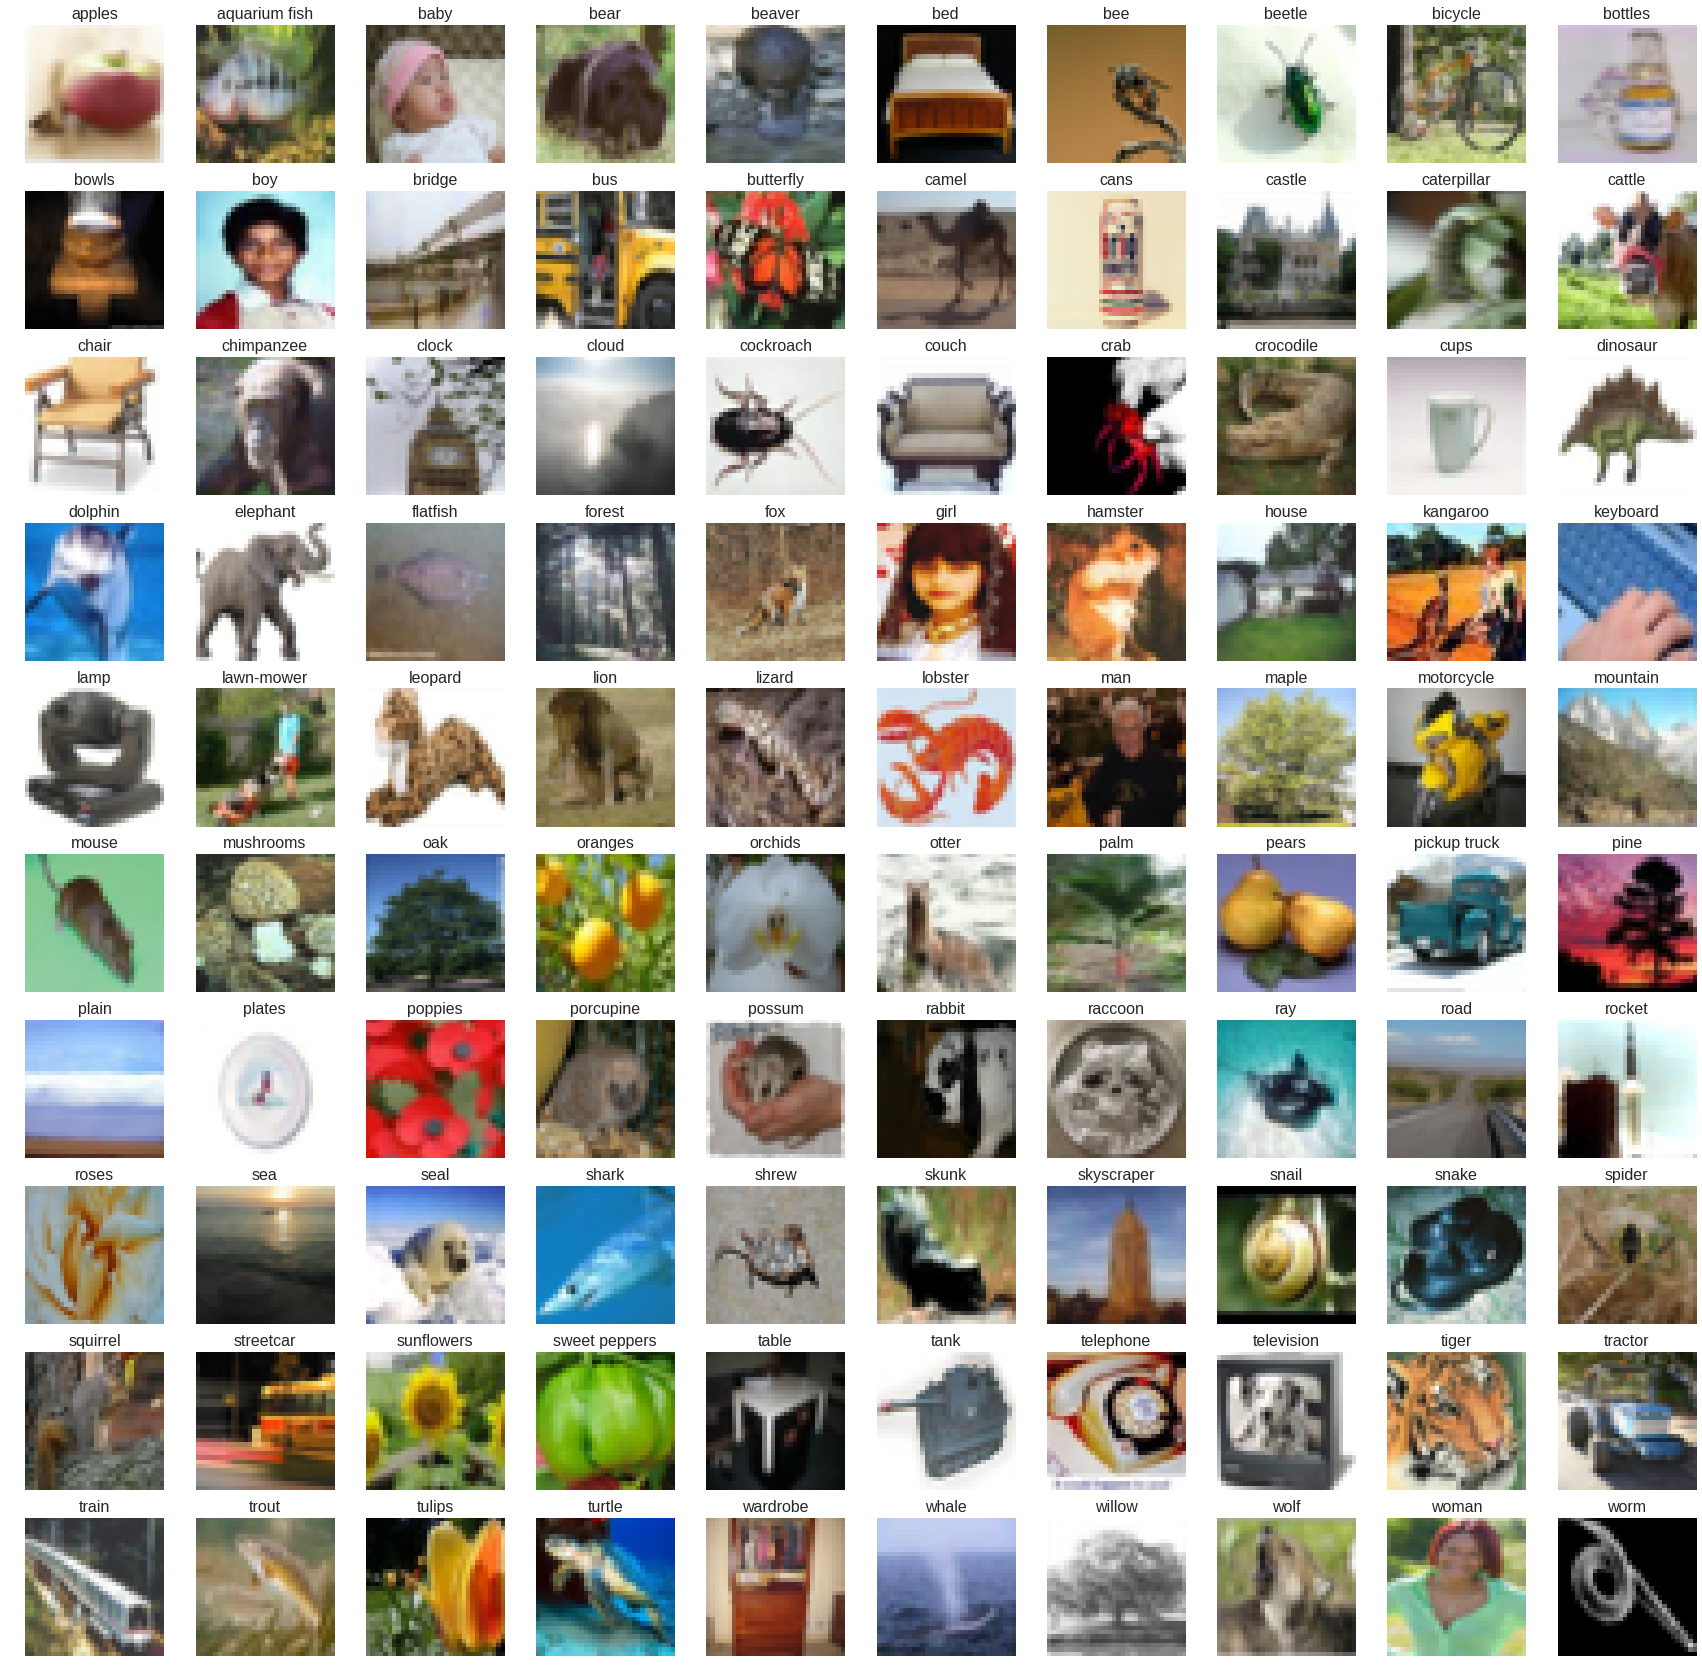

In [162]:
images_indices = []
# get the first index of each class label 
for i in range(100):
    images_indices.append(np.argwhere(y_train == i)[0][0].item())
    				
# plot 1 image of each class label
rows = 10
f = plt.figure(figsize=(30,30))
for i in range(len(images_indices)):
    sp = f.add_subplot(rows, len(images_indices)//rows, i+1)
    sp.axis('Off')
    sp.set_title(labels[i], fontsize=16)
    plt.imshow(x_train[images_indices[i]], cmap=plt.cm.binary)        

### Extract data

Extract all the images from only `boy, girl, man, woman` class.

In [163]:
to_extract = ['boy', 'girl', 'man', 'woman']

target_label = [labels.index(label) for label in to_extract]
print(target_label)

[11, 35, 46, 98]


In [166]:
def extract(target_label):
  train_target = np.isin(y_train, target_label)
  test_target = np.isin(y_test, target_label)
  train_target = train_target.reshape(train_target.size)
  test_target = test_target.reshape(test_target.size)
  x_train_target = x_train[train_target]
  x_test_target = x_test[test_target]
  y_train_target = y_train[train_target]
  y_test_target = y_test[test_target]
  y_train_target = y_train_target.reshape(y_train_target.size)
  y_test_target = y_test_target.reshape(y_test_target.size)
  return (x_train_target, x_test_target, y_train_target, y_test_target)

x_train_target, x_test_target, y_train_target, y_test_target = extract(target_label)

print("x_train_target shape: %s" % (str(x_train_target.shape)))
print("y_train_target shape: %s" % (str(y_train_target.shape)))
print("x_test_target shape: %s" % (str(x_test_target.shape)))
print("y_test_target shape: %s" % (str(y_test_target.shape)))

x_train_target shape: (2000, 32, 32, 3)
y_train_target shape: (2000,)
x_test_target shape: (400, 32, 32, 3)
y_test_target shape: (400,)


Since the pretrained vgg16 model on keras accepts image with minimum size of (47, 47), but the images from cifar have size (32,32), we need to scale the images so that we can use the keras vgg16 model.  

In [0]:
# https://stackoverflow.com/questions/41758385/resizing-images-in-keras-imagedatagenerator-flow-methods

def reshape(new_shape):
  x_train_new = np.empty(shape=(x_train_target.shape[0],)+new_shape)
  for i in range(x_train_target.shape[0]):
    x_train_new[i] = scipy.ndimage.zoom(x_train_target[i], zoom=(1.5, 1.5, 1))
    
  x_test_new = np.empty(shape=(x_test_target.shape[0],)+new_shape)
  for i in range(x_test_target.shape[0]):
    x_test_new[i] = scipy.ndimage.zoom(x_test_target[i], zoom=(1.5, 1.5, 1))
  
  return (x_train_new, x_test_new)
  
new_shape = (48, 48, 3)
x_train_new, x_test_new = reshape(new_shape)

Change the old labels to 0 (female) and 1 (male)

In [0]:
y_train_target[y_train_target == 11] = 1
y_train_target[y_train_target == 46] = 1
y_train_target[y_train_target != 1] = 0

y_test_target[y_test_target == 11] = 1
y_test_target[y_test_target == 46] = 1
y_test_target[y_test_target != 1] = 0

In [169]:
print("x_train_new shape: %s" % (str(x_train_new.shape)))
print("y_train_target shape: %s" % (str(y_train_target.shape)))
print("x_test_new shape: %s" % (str(x_test_new.shape)))
print("y_test_target shape: %s" % (str(y_test_target.shape)))

x_train_new shape: (2000, 48, 48, 3)
y_train_target shape: (2000,)
x_test_new shape: (400, 48, 48, 3)
y_test_target shape: (400,)


In [0]:
x_train_new = x_train_new.astype('float32') / 255
x_test_new = x_test_new.astype('float32') / 255

Plot example images from the new train set

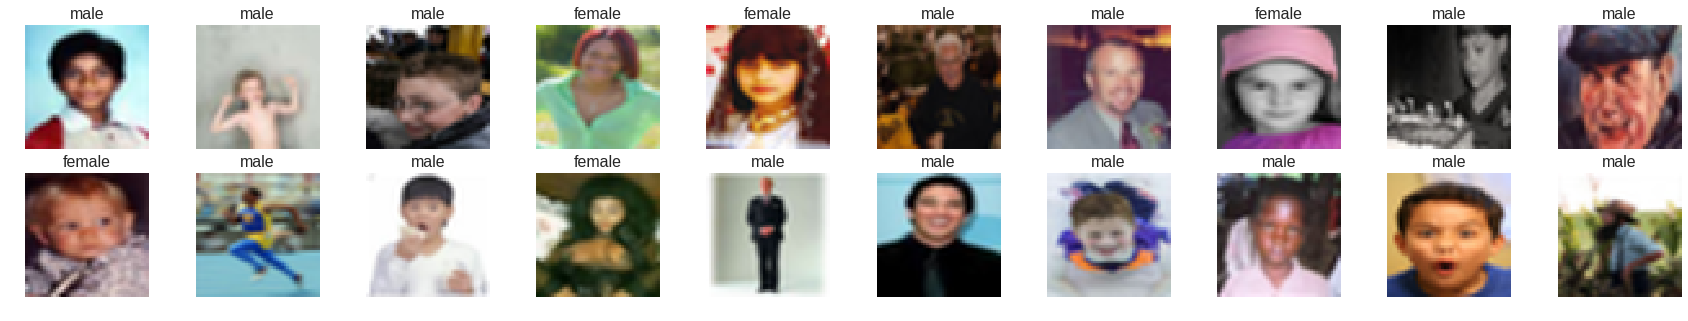

In [171]:
new_labels = ['female', 'male']
    				
rows = 2
f = plt.figure(figsize=(30,5))
for i in range(20):
    sp = f.add_subplot(rows, 20//rows, i+1)
    sp.axis('Off')
    sp.set_title(new_labels[y_train_target[i]], fontsize=16)
    plt.imshow(x_train_new[i])   

Plot example images from the new test set

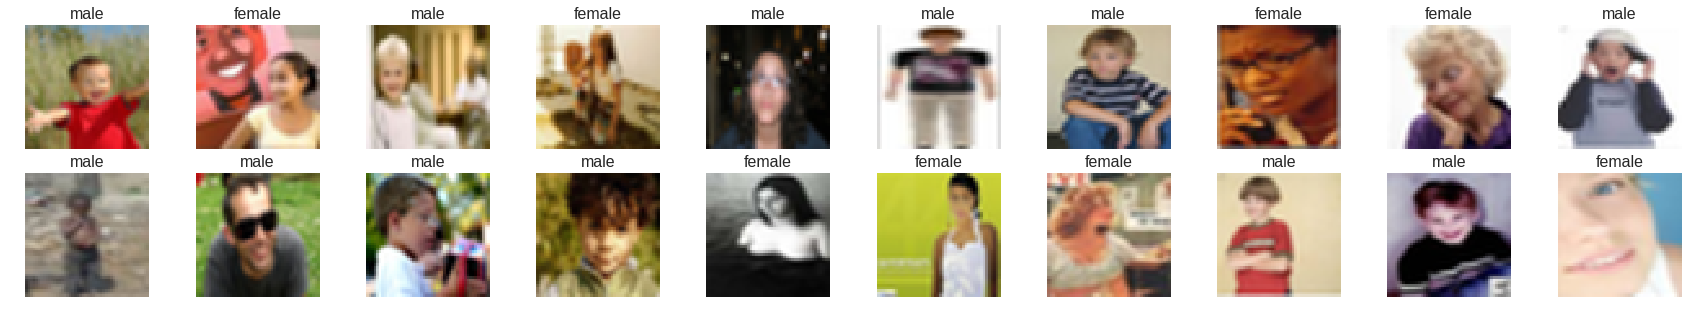

In [172]:
f = plt.figure(figsize=(30,5))
for i in range(20):
    sp = f.add_subplot(rows, 20//rows, i+1)
    sp.axis('Off')
    sp.set_title(new_labels[y_test_target[i]], fontsize=16)
    plt.imshow(x_test_new[i], cmap=plt.cm.binary) 

## Feature extraction

In [173]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=new_shape)

conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
__________

Add Dense layers on top of the `conv_base`

In [174]:
def build_model():
  model = models.Sequential()
  model.add(conv_base)
  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
  model.summary()
  return model

model = build_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_9 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 513       
Total params: 14,977,857
Trainable params: 14,977,857
Non-trainable params: 0
_________________________________________________________________


Freeze the `conv_base`

In [175]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


Train model with data augmentation

In [176]:
train_datagen = image.ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = image.ImageDataGenerator()

def train(model):
  model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])
  return model.fit_generator(train_datagen.flow(x_train_new, y_train_target, batch_size=32),
                      steps_per_epoch=len(x_train_new) / 32, validation_data=test_datagen.flow(x_test_new, y_test_target, batch_size=32), epochs=20)

history = train(model)

Epoch 1/20
63/62 [==============================] - 3s 50ms/step - loss: 0.7251 - acc: 0.4960 - val_loss: 0.6929 - val_acc: 0.5250
Epoch 2/20
63/62 [==============================] - 3s 43ms/step - loss: 0.6905 - acc: 0.5377 - val_loss: 0.6847 - val_acc: 0.5425
Epoch 3/20
63/62 [==============================] - 3s 43ms/step - loss: 0.6889 - acc: 0.5327 - val_loss: 0.6784 - val_acc: 0.5850
Epoch 4/20
63/62 [==============================] - 3s 43ms/step - loss: 0.6776 - acc: 0.5699 - val_loss: 0.6736 - val_acc: 0.5875
Epoch 5/20
63/62 [==============================] - 3s 44ms/step - loss: 0.6767 - acc: 0.5714 - val_loss: 0.6705 - val_acc: 0.6075
Epoch 6/20
63/62 [==============================] - 3s 45ms/step - loss: 0.6767 - acc: 0.5719 - val_loss: 0.6674 - val_acc: 0.6125
Epoch 7/20
39/62 [=================>............] - ETA: 0s - loss: 0.6701 - acc: 0.5881

63/62 [==============================] - 3s 45ms/step - loss: 0.6710 - acc: 0.5803 - val_loss: 0.6657 - val_acc: 0.5925
Epoch 8/20
63/62 [==============================] - 3s 45ms/step - loss: 0.6681 - acc: 0.5903 - val_loss: 0.6632 - val_acc: 0.6075
Epoch 9/20
63/62 [==============================] - 3s 45ms/step - loss: 0.6682 - acc: 0.5962 - val_loss: 0.6615 - val_acc: 0.6000
Epoch 10/20
63/62 [==============================] - 3s 43ms/step - loss: 0.6641 - acc: 0.5977 - val_loss: 0.6602 - val_acc: 0.6050
Epoch 11/20
63/62 [==============================] - 3s 45ms/step - loss: 0.6624 - acc: 0.6047 - val_loss: 0.6583 - val_acc: 0.6025
Epoch 12/20
63/62 [==============================] - 3s 45ms/step - loss: 0.6630 - acc: 0.6052 - val_loss: 0.6574 - val_acc: 0.6125
Epoch 13/20
48/62 [======================>.......] - ETA: 0s - loss: 0.6637 - acc: 0.5918

63/62 [==============================] - 3s 44ms/step - loss: 0.6606 - acc: 0.5977 - val_loss: 0.6561 - val_acc: 0.6225
Epoch 14/20
63/62 [==============================] - 3s 43ms/step - loss: 0.6567 - acc: 0.6037 - val_loss: 0.6549 - val_acc: 0.6100
Epoch 15/20
63/62 [==============================] - 3s 44ms/step - loss: 0.6603 - acc: 0.5962 - val_loss: 0.6536 - val_acc: 0.6100
Epoch 16/20
63/62 [==============================] - 3s 44ms/step - loss: 0.6552 - acc: 0.6146 - val_loss: 0.6520 - val_acc: 0.6200
Epoch 17/20
63/62 [==============================] - 3s 44ms/step - loss: 0.6567 - acc: 0.6012 - val_loss: 0.6520 - val_acc: 0.6150
Epoch 18/20
63/62 [==============================] - 3s 45ms/step - loss: 0.6552 - acc: 0.6131 - val_loss: 0.6510 - val_acc: 0.6000
Epoch 19/20
43/62 [===================>..........] - ETA: 0s - loss: 0.6534 - acc: 0.5952

63/62 [==============================] - 3s 44ms/step - loss: 0.6531 - acc: 0.5977 - val_loss: 0.6502 - val_acc: 0.6150
Epoch 20/20
63/62 [==============================] - 3s 45ms/step - loss: 0.6566 - acc: 0.6096 - val_loss: 0.6489 - val_acc: 0.6225


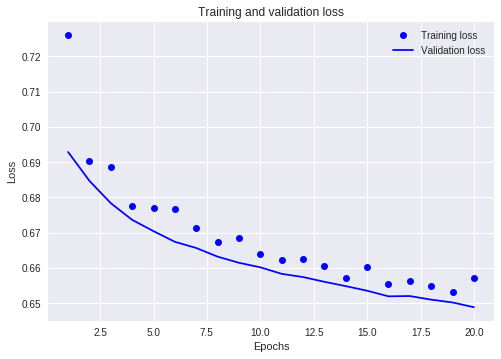

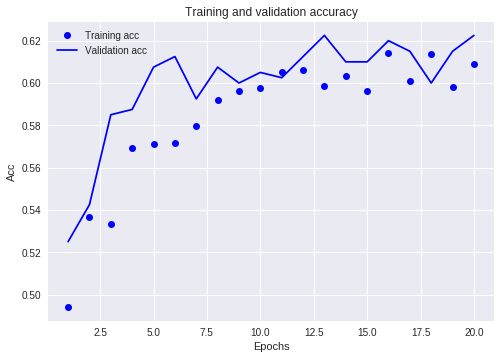

In [177]:
def plot(hist):
  """
  Plot the training/validation loss/accuracy graphs  
  """
  loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  epochs = range(1, len(loss) + 1)

  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

  acc = hist.history['acc']
  val_acc = hist.history['val_acc']

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Acc')
  plt.legend()
  plt.show()

plot(history)

Using feature extraction on the pretrained vgg16 model from keras, we got over 60% accuracy on this gender detection problem, not much better than baseline 50%.

# Vehicles vs People

With not much success from the previous problem, we attempt to detect human from vehicles, which I guess could be an easier problem and also useful for self-driving car. 

## Prepare data

### Load data

We also use the cifar100 dataset, but this time we get the 20 superclasses instead of 100 classes.

In [0]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='coarse')

### Explore data

In [179]:
print("x_train shape: %s" % (str(x_train.shape)))
print("y_train shape: %s" % (str(y_train.shape)))
print("x_test shape: %s" % (str(x_test.shape)))
print("y_test shape: %s" % (str(y_test.shape)))

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


In [180]:
# https://www.cs.toronto.edu/~kriz/cifar.html
labels = """aquatic mammals
fish
flowers
food containers
fruit and vegetables
household electrical devices
household furniture
insects
large carnivores
large man-made outdoor things
large natural outdoor scenes
large omnivores and herbivores
medium-sized mammals
non-insect invertebrates
people
reptiles
small mammals
trees
vehicles 1
vehicles 2""".replace('\n', ', ')

labels = labels.split(', ')
print(labels)

['aquatic mammals', 'fish', 'flowers', 'food containers', 'fruit and vegetables', 'household electrical devices', 'household furniture', 'insects', 'large carnivores', 'large man-made outdoor things', 'large natural outdoor scenes', 'large omnivores and herbivores', 'medium-sized mammals', 'non-insect invertebrates', 'people', 'reptiles', 'small mammals', 'trees', 'vehicles 1', 'vehicles 2']


Plot example image of every class

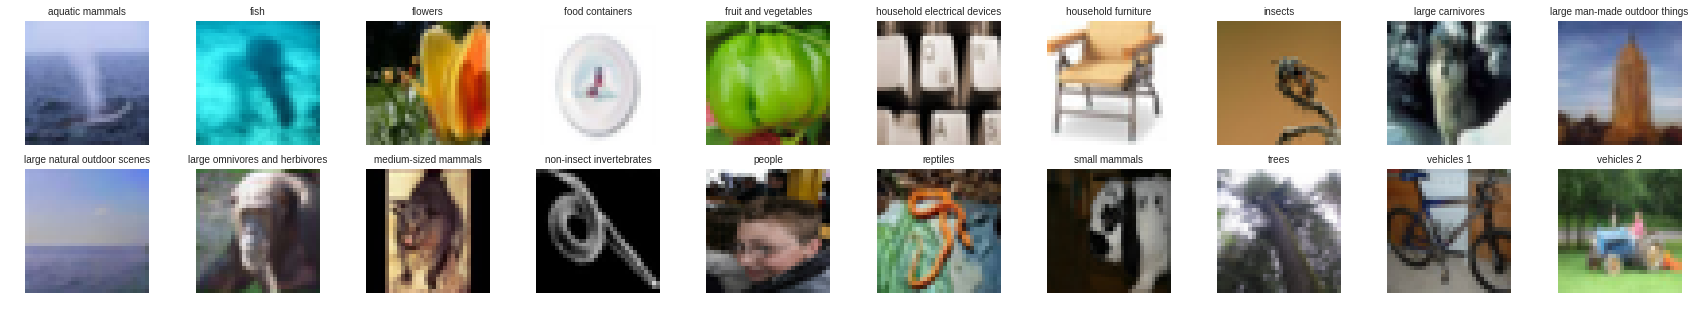

In [181]:
images_indices = []
# get the first index of each class label 
for i in range(20):
    images_indices.append(np.argwhere(y_train == i)[2][0].item())
    				
# plot 1 image of each class label
rows = 2
f = plt.figure(figsize=(30,5))
for i in range(len(images_indices)):
    sp = f.add_subplot(rows, len(images_indices)//rows, i+1)
    sp.axis('Off')
    sp.set_title(labels[i], fontsize=10)
    plt.imshow(x_train[images_indices[i]], cmap=plt.cm.binary)        

### Extract data

Extract all the images from only `peole` and `vehicles 1` classes.

In [182]:
to_extract = ['people', 'vehicles 1']

target_label = [labels.index(label) for label in to_extract]
print(target_label)

[14, 18]


In [183]:
x_train_target, x_test_target, y_train_target, y_test_target = extract(target_label)

print("x_train_target shape: %s" % (str(x_train_target.shape)))
print("y_train_target shape: %s" % (str(y_train_target.shape)))
print("x_test_target shape: %s" % (str(x_test_target.shape)))
print("y_test_target shape: %s" % (str(y_test_target.shape)))

x_train_target shape: (5000, 32, 32, 3)
y_train_target shape: (5000,)
x_test_target shape: (1000, 32, 32, 3)
y_test_target shape: (1000,)


Scale the images so that we can use the keras vgg16 model.  

In [0]:
x_train_new, x_test_new = reshape(new_shape)

Change the old labels to 0 (vehicles) or 1 (human)

In [0]:
y_train_target[y_train_target == 14] = 1
y_train_target[y_train_target != 1] = 0

y_test_target[y_test_target == 14] = 1
y_test_target[y_test_target != 1] = 0

In [186]:
print("x_train_new shape: %s" % (str(x_train_new.shape)))
print("y_train_target shape: %s" % (str(y_train_target.shape)))
print("x_test_new shape: %s" % (str(x_test_new.shape)))
print("y_test_target shape: %s" % (str(y_test_target.shape)))

x_train_new shape: (5000, 48, 48, 3)
y_train_target shape: (5000,)
x_test_new shape: (1000, 48, 48, 3)
y_test_target shape: (1000,)


In [0]:
x_train_new = x_train_new.astype('float32') / 255
x_test_new = x_test_new.astype('float32') / 255

Plot example images of the new train set

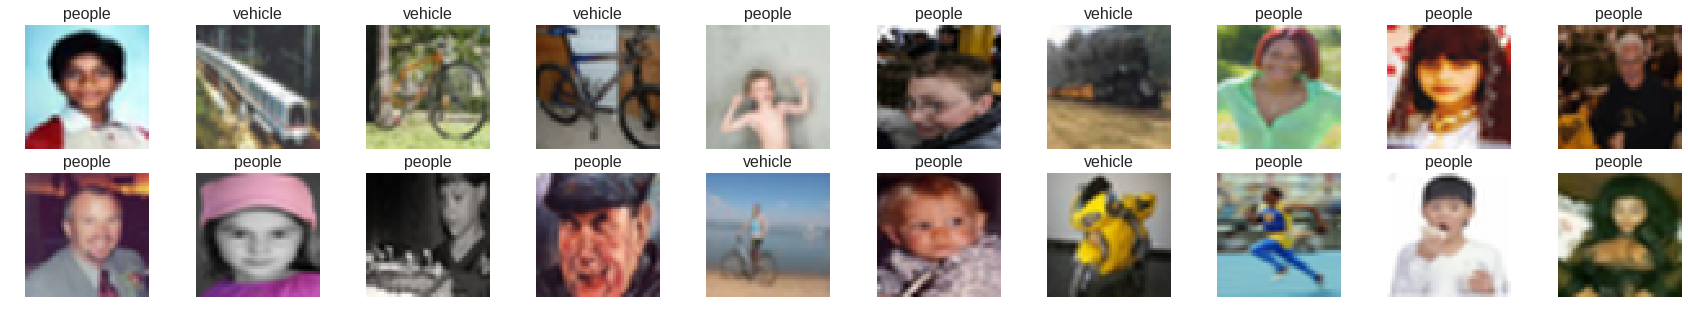

In [188]:
new_labels = ['vehicle', 'people']
    				
rows = 2
f = plt.figure(figsize=(30,5))
for i in range(20):
    sp = f.add_subplot(rows, 20//rows, i+1)
    sp.axis('Off')
    sp.set_title(new_labels[y_train_target[i]], fontsize=16)
    plt.imshow(x_train_new[i])   

## Feature extraction

In [191]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=new_shape)

model = build_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_11 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 513       
Total params: 14,977,857
Trainable params: 14,977,857
Non-trainable params: 0
_________________________________________________________________


In [192]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


In [193]:
history = train(model)

Epoch 1/20
157/156 [==============================] - 8s 51ms/step - loss: 0.6655 - acc: 0.6162 - val_loss: 0.5927 - val_acc: 0.7570
Epoch 2/20
157/156 [==============================] - 7s 46ms/step - loss: 0.5882 - acc: 0.7329 - val_loss: 0.5266 - val_acc: 0.8150
Epoch 3/20
157/156 [==============================] - 7s 47ms/step - loss: 0.5393 - acc: 0.7657 - val_loss: 0.4810 - val_acc: 0.8200
Epoch 4/20
157/156 [==============================] - 7s 46ms/step - loss: 0.5153 - acc: 0.7693 - val_loss: 0.4518 - val_acc: 0.8280
Epoch 5/20
 19/156 [==>...........................] - ETA: 4s - loss: 0.4826 - acc: 0.8026

157/156 [==============================] - 7s 46ms/step - loss: 0.4848 - acc: 0.7942 - val_loss: 0.4298 - val_acc: 0.8310
Epoch 6/20
157/156 [==============================] - 7s 46ms/step - loss: 0.4712 - acc: 0.7892 - val_loss: 0.4117 - val_acc: 0.8460
Epoch 7/20
157/156 [==============================] - 7s 46ms/step - loss: 0.4637 - acc: 0.7972 - val_loss: 0.4005 - val_acc: 0.8390
Epoch 8/20
157/156 [==============================] - 7s 45ms/step - loss: 0.4487 - acc: 0.8059 - val_loss: 0.3926 - val_acc: 0.8380
Epoch 9/20
 33/156 [=====>........................] - ETA: 4s - loss: 0.4456 - acc: 0.7973

157/156 [==============================] - 7s 45ms/step - loss: 0.4478 - acc: 0.7970 - val_loss: 0.3812 - val_acc: 0.8490
Epoch 10/20
157/156 [==============================] - 7s 45ms/step - loss: 0.4383 - acc: 0.8069 - val_loss: 0.3739 - val_acc: 0.8520
Epoch 11/20
157/156 [==============================] - 7s 45ms/step - loss: 0.4326 - acc: 0.8077 - val_loss: 0.3690 - val_acc: 0.8530
Epoch 12/20
157/156 [==============================] - 7s 45ms/step - loss: 0.4183 - acc: 0.8181 - val_loss: 0.3675 - val_acc: 0.8440
Epoch 13/20
 29/156 [====>.........................] - ETA: 4s - loss: 0.3983 - acc: 0.8254

157/156 [==============================] - 7s 45ms/step - loss: 0.4191 - acc: 0.8105 - val_loss: 0.3585 - val_acc: 0.8550
Epoch 14/20
157/156 [==============================] - 7s 46ms/step - loss: 0.4134 - acc: 0.8177 - val_loss: 0.3583 - val_acc: 0.8500
Epoch 15/20
157/156 [==============================] - 7s 46ms/step - loss: 0.4055 - acc: 0.8217 - val_loss: 0.3496 - val_acc: 0.8620
Epoch 16/20
157/156 [==============================] - 7s 46ms/step - loss: 0.4046 - acc: 0.8250 - val_loss: 0.3461 - val_acc: 0.8580
Epoch 17/20
 27/156 [====>.........................] - ETA: 4s - loss: 0.3870 - acc: 0.8322

157/156 [==============================] - 7s 46ms/step - loss: 0.3953 - acc: 0.8286 - val_loss: 0.3445 - val_acc: 0.8580
Epoch 18/20
157/156 [==============================] - 7s 46ms/step - loss: 0.4027 - acc: 0.8280 - val_loss: 0.3408 - val_acc: 0.8620
Epoch 19/20
157/156 [==============================] - 7s 46ms/step - loss: 0.3923 - acc: 0.8223 - val_loss: 0.3412 - val_acc: 0.8550
Epoch 20/20
157/156 [==============================] - 7s 48ms/step - loss: 0.3993 - acc: 0.8207 - val_loss: 0.3330 - val_acc: 0.8690


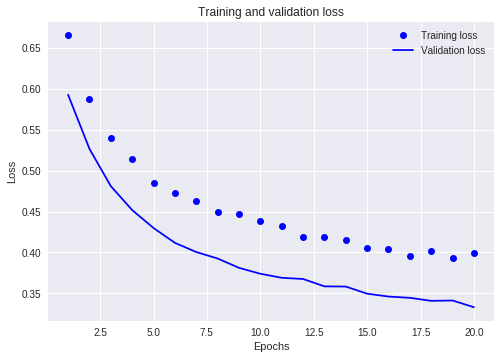

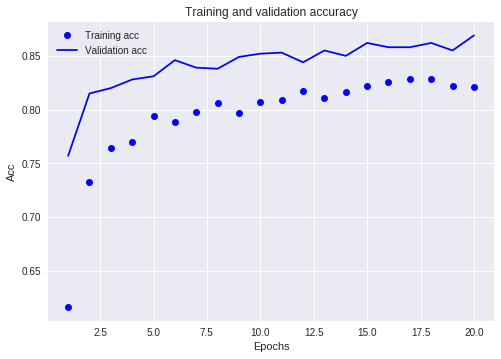

In [194]:
plot(history)

We reached about 87% accuracy with the same model of the previous problem, so obviously detecting human from vehicles is easier than detecting genders.